# Perspective analysis

Uploading libraries 

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import linprog
from scipy.optimize import minimize

Uploading the data in df

In [ ]:
df = pd.read_csv(R'Ecommerce_Sales_Dataset.csv')
print(df.head())

         Date Product_Category   Price  Discount Customer_Segment  \
0  01/01/2023           Sports  932.80     35.82       Occasional   
1  02/01/2023             Toys  569.48      3.60          Premium   
2  03/01/2023       Home Decor  699.68      3.56          Premium   
3  04/01/2023             Toys  923.27      0.61          Premium   
4  05/01/2023             Toys  710.17     47.83          Premium   

   Marketing_Spend  Units_Sold  
0          6780.38          32  
1          6807.56          16  
2          3793.91          27  
3          9422.75          29  
4          1756.83          17  


# Doing a linear programming Model

Pre-processing the data

In [89]:
df2 = df.copy()
df2['Date'] = pd.to_datetime(df['Date'], dayfirst = True)
df2['Date'] = df2['Date'].dt.month
df2.head()

,Date,Product_Category,Price,Discount,Customer_Segment,Marketing_Spend,Units_Sold
0,1,Sports,932.80,35.82,Occasional,6780.38,32
1,1,Toys,569.48,3.60,Premium,6807.56,16
2,1,Home Decor,699.68,3.56,Premium,3793.91,27
3,1,Toys,923.27,0.61,Premium,9422.75,29
4,1,Toys,710.17,47.83,Premium,1756.83,17


Setting up the target and feature variables

In [90]:
X_num = df[['Price', 'Discount', 'Marketing_Spend']].values     
n_samples = X_num.shape[0]
X = np.hstack([np.ones((n_samples, 1)), X_num])
y = df['Units_Sold'].values  

Getting the objective, which is a mean squared error

In [91]:
def mse_loss(w):
    preds = X @ w               
    return np.mean((preds - y) ** 2)


Configuration and launching the optimizer

In [92]:
bounds = [(-5.0, 0.0)] * 4           
w0 = np.full(4, -2.5)                   

result = minimize(
    mse_loss,
    w0,
    method='L-BFGS-B',
    bounds=bounds,
)

Printing out the outcome

In [93]:
w_opt = result.x
print("\nOptimal weights (constrained to -5 … 0):")
print(f"  w1 (intercept)     = {w_opt[0]:.4f}")
print(f"  w2 (Price)         = {w_opt[1]:.4f}")
print(f"  w3 (Discount)      = {w_opt[2]:.4f}")
print(f"  w4 (MarketingSpend)= {w_opt[3]:.4f}")
print(f"\nConstrained MSE      = {result.fun:.4f}")


Optimal weights (constrained to -5 … 0):
  w1 (intercept)     = 0.0000
  w2 (Price)         = 0.0000
  w3 (Discount)      = 0.0000
  w4 (MarketingSpend)= 0.0000

Constrained MSE      = 930.7670


# Genetic code algorithm

Pre-processing data

In [94]:
price = df['Price'].values
discount = df['Discount'].values
marketing = df['Marketing_Spend'].values
units_sold = df['Units_Sold'].values

X = np.vstack([np.ones_like(price),  
               price,              
               discount,              
               marketing              
               ]).T    


In [95]:
def mse_loss(weights):
   
    y_pred = X @ weights
    return np.mean((y_pred - units_sold) ** 2)

def fitness(weights): 
    return -mse_loss(weights)


In [96]:
POP_SIZE = 30
N_GEN = 50         
ELITE_COUNT = 4
CROSSOVER_P = 0.9
MUTATE_P = 0.2
N_RUNS = 10 
WEIGHT_BOUNDS = [(-10, 10)] * 4


In [97]:
def enforce_diversity(pop, bounds, pop_size, rng):

    rounded = np.round(pop, 6)
    _, uniq_idx = np.unique(rounded, axis=0, return_index=True)
    unique = pop[np.sort(uniq_idx)]

    n_missing = pop_size - len(unique)
    if n_missing > 0:
        lows, highs = zip(*bounds)                
        lows, highs = np.array(lows), np.array(highs)
        fresh = rng.uniform(lows, highs,
                            size=(n_missing, pop.shape[1]))
        unique = np.vstack([unique, fresh])

    return unique         


In [98]:
def run_ga(seed):
    rng = np.random.default_rng(seed)
    # initial population
    pop = rng.uniform(-10, 10, size=(POP_SIZE, 4))
    history_best = []

    for gen in range(N_GEN):
        # evaluate
        fit_vals = np.apply_along_axis(fitness, 1, pop)
        # record best
        best_idx = np.argmax(fit_vals)
        history_best.append((gen, -fit_vals[best_idx], pop[best_idx].copy()))  # store MSE (positive)
        
        # elitism
        elite_idx = np.argsort(fit_vals)[-ELITE_COUNT:]
        elites = pop[elite_idx].copy()

        # selection (roulette)
        probs = (fit_vals - fit_vals.min() + 1e-8)
        probs = probs / probs.sum()
        selected = pop[rng.choice(np.arange(POP_SIZE),
                                  size=POP_SIZE - ELITE_COUNT,
                                  replace=True,
                                  p=probs)].copy()

        # create next generation skeleton
        new_pop = np.vstack([elites, selected])

        # crossover
        for i in range(ELITE_COUNT, POP_SIZE-1, 2):
            if rng.random() < CROSSOVER_P:
                cp = rng.integers(1, 4)  # choose crossover point 1..3
                a, b = new_pop[i].copy(), new_pop[i+1].copy()
                new_pop[i, cp:], new_pop[i+1, cp:] = b[cp:], a[cp:]

        # mutation
        span = np.array([b[1]-b[0] for b in WEIGHT_BOUNDS])
        for i in range(ELITE_COUNT, POP_SIZE):
            for j in range(4):
                if rng.random() < MUTATE_P:
                    delta = rng.normal(0, 0.05 * span[j])  # 5% of range
                    new_pop[i, j] = np.clip(new_pop[i, j] + delta,
                                            WEIGHT_BOUNDS[j][0],
                                            WEIGHT_BOUNDS[j][1])
        new_pop = enforce_diversity(new_pop,
                            WEIGHT_BOUNDS,
                            POP_SIZE,
                            rng)       

        pop = new_pop

    # final evaluation
    fit_vals = np.apply_along_axis(fitness, 1, pop)
    best_idx = np.argmax(fit_vals)
    best_weights = pop[best_idx].copy()
    best_mse = -fit_vals[best_idx]
    return best_weights, best_mse, history_best


In [99]:
all_runs = []
for r in range(N_RUNS):
    w, mse_val, hist = run_ga(seed=42 + r)
    all_runs.append({'run': r+1,
                     'weights': w,
                     'mse': mse_val,
                     'history': hist})

In [100]:
best_run = min(all_runs, key=lambda d: d['mse'])
best_w = best_run['weights']

In [101]:
print("=== Best GA Run ===")
print(f"MSE: {best_run['mse']:.4f}")
print(f"W1 (intercept): {best_w[0]:.4f}")
print(f"W2 (Price):      {best_w[1]:.4f}")
print(f"W3 (Discount):   {best_w[2]:.4f}")
print(f"W4 (Marketing):  {best_w[3]:.4f}")

=== Best GA Run ===
MSE: 685.6663
W1 (intercept): 3.9476
W2 (Price):      0.0064
W3 (Discount):   -0.7741
W4 (Marketing):  0.0080


# Plot the predicted number of sold units values against the actual number of sold units

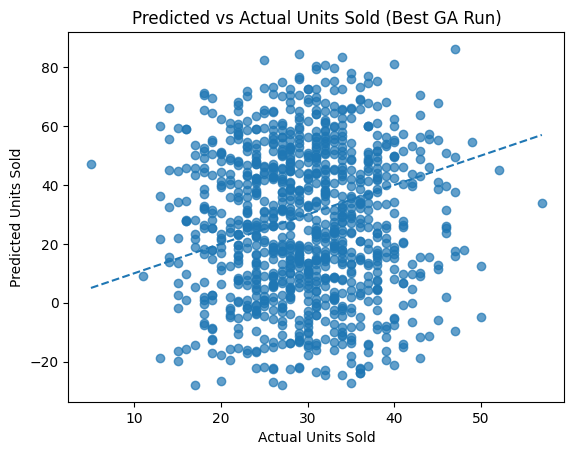

In [102]:
plt.figure()
plt.scatter(units_sold, X @ best_w, alpha=0.7)
plt.plot([units_sold.min(), units_sold.max()],
         [units_sold.min(), units_sold.max()], linestyle='--')
plt.xlabel('Actual Units Sold')
plt.ylabel('Predicted Units Sold')
plt.title('Predicted vs Actual Units Sold (Best GA Run)')
plt.show()

# Analyze and visualize the convergence behavior

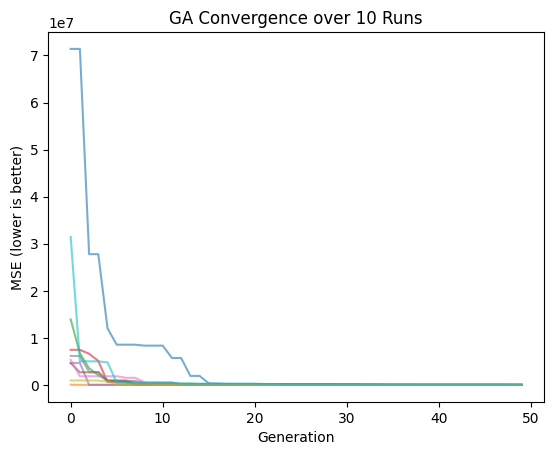

In [103]:
plt.figure()
for run in all_runs:
    gens = [g for g, mse_val, _ in run['history']]
    mses = [mse_val for _, mse_val, _ in run['history']]
    plt.plot(gens, mses, alpha=0.6)
plt.xlabel('Generation')
plt.ylabel('MSE (lower is better)')
plt.title('GA Convergence over 10 Runs')
plt.show()

# boxplots to visualize and compare the final performance

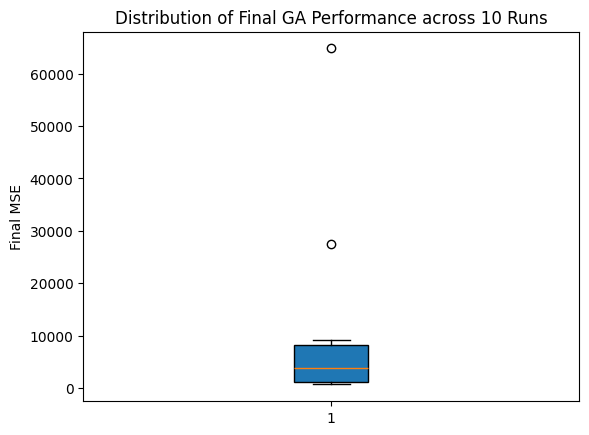

In [104]:
plt.figure()
plt.boxplot([run['mse'] for run in all_runs], vert=True, patch_artist=True)
plt.ylabel('Final MSE')
plt.title('Distribution of Final GA Performance across 10 Runs')
plt.show()
